In [4]:

import numpy as np
import matplotlib.pyplot as plt
import torch as T
import pickle
device = T.device("cuda:0")  # apply to Tensor or Module
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import glob
#path = "/mnt/d/Work/Dissertation/Preprocessing/VNIR-Field1/"
#onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
import torch
import struct
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from tqdm import tqdm

In [5]:
"""with open("periya_images.pickle","wb") as f:
    pickle.dump(crop_images,f)"""

with open("periya_images.pickle","rb") as f:
    crop_images=pickle.load(f)
crop_images = torch.tensor(crop_images,dtype=T.float32)
crop_images.to(device)

tensor([[[[0.0901, 0.0905, 0.0909,  ..., 0.0708, 0.0704, 0.0711],
          [0.1018, 0.0931, 0.0869,  ..., 0.0703, 0.0711, 0.0657],
          [0.0925, 0.0898, 0.0857,  ..., 0.0711, 0.0665, 0.0582],
          ...,
          [0.0639, 0.0603, 0.0551,  ..., 0.0586, 0.0780, 0.1233],
          [0.0630, 0.0481, 0.0684,  ..., 0.0786, 0.1079, 0.1404],
          [0.0623, 0.0571, 0.0522,  ..., 0.0702, 0.1402, 0.2073]],

         [[0.0966, 0.0971, 0.1000,  ..., 0.0726, 0.0717, 0.0763],
          [0.1085, 0.1008, 0.1035,  ..., 0.0714, 0.0763, 0.0812],
          [0.0949, 0.1021, 0.1045,  ..., 0.0763, 0.0804, 0.0879],
          ...,
          [0.0612, 0.0580, 0.0555,  ..., 0.0677, 0.0934, 0.1563],
          [0.0615, 0.0543, 0.0558,  ..., 0.0960, 0.1360, 0.1765],
          [0.0634, 0.0579, 0.0566,  ..., 0.0713, 0.1809, 0.2196]],

         [[0.0996, 0.0891, 0.1016,  ..., 0.0691, 0.0695, 0.0647],
          [0.1112, 0.0994, 0.1025,  ..., 0.0698, 0.0647, 0.0610],
          [0.0944, 0.0976, 0.1035,  ..., 0

In [9]:
crop_images.shape

torch.Size([23, 270, 164, 164])

In [6]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [7]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enc1 = T.nn.Conv2d(270, 350, 3)  # 64-16-2-16-64
    self.enc2 = T.nn.Conv2d(350, 400, 3) 
    self.enc3 = T.nn.Conv2d(400, 540 , 3)
    self.enc4 = T.nn.Conv2d(540, 610 , 3)
    self.enc5 = T.nn.Conv2d(610, 810 , 3)
    self.enc6 = T.nn.Conv2d(810, 810 , 3)
    self.enc7 = T.nn.Conv2d(810, 810 , 3)
    self.enc8 = T.nn.Conv2d(810, 810 , 3)
    self.enc9 = T.nn.Conv2d(810, 810 , 3)
    self.pool = T.nn.MaxPool2d(2, return_indices=True)
    self.unpool=T.nn.MaxUnpool2d(2)
    self.dec0 = T.nn.ConvTranspose2d(810, 810, 3)
    self.dec1 = T.nn.ConvTranspose2d(810, 810, 3)
    self.dec2 = T.nn.ConvTranspose2d(810, 810, 3)
    self.dec3 = T.nn.ConvTranspose2d(810, 810, 3)
    self.dec4 = T.nn.ConvTranspose2d(810, 610, 3)
    self.dec5 = T.nn.ConvTranspose2d(610, 540, 3)
    self.dec6 = T.nn.ConvTranspose2d(540, 400, 3)
    self.dec7 = T.nn.ConvTranspose2d(400, 350, 3)
    self.dec8 = T.nn.ConvTranspose2d(350, 270, 3)
  
    T.nn.init.xavier_uniform_(self.enc1.weight)
    T.nn.init.zeros_(self.enc1.bias)
    T.nn.init.xavier_uniform_(self.enc2.weight)
    T.nn.init.zeros_(self.enc2.bias)
    T.nn.init.xavier_uniform_(self.dec1.weight)
    T.nn.init.zeros_(self.dec1.bias)
    T.nn.init.xavier_uniform_(self.dec2.weight)
    T.nn.init.zeros_(self.dec2.bias)

  def encode(self, x):
    
    z = T.relu(self.enc1(x))
    z=self.pool(z)
    z = T.relu(self.enc2(z))
    z=self.pool(z)
    z = T.relu(self.enc3(z))
    z=self.pool(z)
    z = T.relu(self.enc4(z))
    z=self.pool(z)
    z = T.relu(self.enc5(z))
    z=self.pool(z)
    #z = T.relu(self.enc6(z))
    #z = T.relu(self.enc7(z))
    #z = T.relu(self.enc8(z))
    #z = T.relu(self.enc9(z))
     # act depends on scenario
    return z.to(device)

  def decode(self, x):
    #z = T.relu(self.dec1(x))
    #z = T.relu(self.dec1(z))
    #z = T.relu(self.dec2(z))
    #z = T.relu(self.dec3(z))
    
    z = T.relu(self.dec4(x))
    z = self.unpool(z)
    z = T.relu(self.dec5(z))  # no activation
    z = self.unpool(z)
    z = T.relu(self.dec6(z))
    z=self.unpool(z)
    z = T.relu(self.dec7(z))
    z=self.unpool(z)
    z = self.dec8(z)
    
    return z   

  def forward(self, x):
    
    z = self.encode(x)
    z = self.decode(z)
    return z



In [8]:
net=Net().to(device)
inpu=torch.rand(1,270,164,164).to(device)
out=net(inpu)
out.shape

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [5]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 3
train_ldr = T.utils.data.DataLoader(crop_images,
batch_size=bat_size, shuffle=True)
train_ldr
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 250
ep_log_interval = 10
lrn_rate = 0.001

loss_func1 = T.nn.MSELoss()
loss_func = T.nn.L1Loss(reduction='sum')
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0
  for (batch_idx, batch) in loop:
    X = batch.to(device)  # no targets needed

    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, X)  # note: X not Y
    loss_obj1=loss_func1(oupt,X)
    epoch_loss += loss_obj.item()  # accumulate
    mseloss+=loss_obj1.item()
    loss_obj.backward()
    optimizer.step()

    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss),mseloss=str(mseloss))
"""
  if epoch % ep_log_interval == 0:
    print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")"""

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 

bat_size =   3 
loss = L1Loss()
optimizer = Adam
max_epochs = 250 
lrn_rate = 0.001 

Starting training


Epoch [206/250]:  25%|██▌       | 2/8 [00:06<00:18,  3.15s/it, loss=596845.90625, mseloss=0.0007694211672060192]


KeyboardInterrupt: 

In [ ]:
#torch.save(net.state_dict(), 'hari_model_sample.pth')
torch.save(net, 'hari_model_struct.pth')

In [ ]:
oupt.shape,X.shape

In [ ]:
#net = torch.load('hari_model_struct.pth')
"""net=Net()
net.load_state_dict(torch.load('hari_model_sample.pth'))
net.to(device)"""

In [9]:
for i in train_ldr:
    break
out=net(i.to(device))
plt.imshow(i[1][0])

RuntimeError: CUDA out of memory. Tried to allocate 210.00 MiB (GPU 0; 8.00 GiB total capacity; 6.09 GiB already allocated; 0 bytes free; 7.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

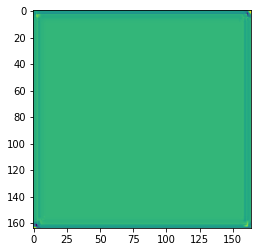

In [8]:
plt.imshow(out[1][0].to("cpu").detach().numpy())

In [8]:
loss_func(out[0][0].to("cpu"), i[0][0].to("cpu"))

NameError: name 'i' is not defined

In [ ]:
i[0][0]

In [ ]:
out[0][0]

In [ ]:
bow=crop_images.to(device)
xy = net.encode(bow).to(device)
xy = xy.to("cpu").detach().numpy()  

In [ ]:
  with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=crop_images.to(device)
    xy = net.encode(bow)  # (1797,2)
  lbls = train_ds[:]['digit']  # (1797,)
  lbls=lbls.to(device)
  xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
  lbls = lbls.to("cpu").detach().numpy()
  
  

  fig, ax = plt.subplots()
  colors = ['red', 'blue', 'green', 'yellow', 'orange',
            'black', 'brown', 'purple', 'silver', 'pink']
  digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
            ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

  # process by each color/class
  for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
    rows = []                   # select rows for curr color
    for j in range(len(xy)):    # 0 to 1796
      if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
      else:
        rows.append(False)

    rows = np.array(rows, dtype=np.bool)  # list to array
    selected = xy[rows,:]                 # like (178,2)

    x = selected[:,0]  # like (178,)
    y = selected[:,1]
    scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
    # and continue on to next color/class

  txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
    "3=yellow \n" + "4=orange \n" + "5=black \n" + \
    "6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
  ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
    verticalalignment='top', bbox=props)
  ax.grid(True)
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.show()

  print("\nEnd UCI digits auto-reduce-viz demo")


main()

In [ ]:
bow

In [ ]:
train_ds

In [ ]:
train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file)

In [ ]:
main.lbls

In [ ]:
# -----------------------------------------------------------


# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

# 1. create DataLoader object
print("\nCreating UCI Digits Dataset ")

train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file) # all 1797 rows


bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds,
batch_size=bat_size, shuffle=True)

# 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 200
ep_log_interval = 10
lrn_rate = 0.01

loss_func = T.nn.MSELoss()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()
for epoch in range(0, max_epochs):
    epoch_loss = 0  # for one full epoch

    for (batch_idx, batch) in enumerate(train_ldr):
        X = batch['pixels'].to(device)  # no targets needed

        optimizer.zero_grad()
        oupt = net(X)
        loss_obj = loss_func(oupt, X)  # note: X not Y
        epoch_loss += loss_obj.item()  # accumulate
        loss_obj.backward()
        optimizer.step()

    if epoch % ep_log_interval == 0:
        print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()

with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=bow.to(device)
    xy = net.encode(bow)  # (1797,2)
    lbls = train_ds[:]['digit']  # (1797,)
    lbls=lbls.to(device)
    xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
    lbls = lbls.to("cpu").detach().numpy()



fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'yellow', 'orange',
        'black', 'brown', 'purple', 'silver', 'pink']
digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
        ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

# process by each color/class
for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
rows = []                   # select rows for curr color
for j in range(len(xy)):    # 0 to 1796
    if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
    else:
        rows.append(False)

rows = np.array(rows, dtype=np.bool)  # list to array
selected = xy[rows,:]                 # like (178,2)

x = selected[:,0]  # like (178,)
y = selected[:,1]
scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
# and continue on to next color/class

txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
"3=yellow \n" + "4=orange \n" + "5=black \n" + \
"6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
verticalalignment='top', bbox=props)
ax.grid(True)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

print("\nEnd UCI digits auto-reduce-viz demo")


In [ ]:
lbls.shape

In [ ]:
lbls

In [ ]:
xy

In [ ]:
plt.scatter(xy[:,0],xy[:,1])

In [ ]:
xy[:,0].shape

In [ ]:
xy[:,0].shape